# Mise en évidence de l'effet de site

## Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import pandas as pd

In [3]:
import os
from glob import glob

In [4]:
from obspy import read, read_inventory, UTCDateTime, Stream
from obspy.clients.fdsn import Client
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.invsim import estimate_wood_anderson_amplitude

## Outils pour l'analyse de données

In [5]:
client = Client("RESIF") # Réseau français

In [6]:
stations = {'WALT', 'HOHE', 'CIEL', 'WLS', 'NEEW', 'SZBH', 'STR', 'ILLF', 'ZELS'}
direction_plans = {"horizontale" : ("N", "E", "W", "S", "1", "2",), "verticale" : ("Z",)}
path = 'data/'
filename = 'data'

In [62]:
# Séisme induit de Strasbourg de référence
starttime = UTCDateTime(2021,6,26,3,0,0)
duration = 3*60
location = (48.66, 7.82)

### Récupération des données/métadonnées des stations
Note : Les données semblent disponible qu'à partir de 2011.

In [46]:
def get_S(name, starttime=starttime, duration=duration):
    return client.get_waveforms("FR", name, "00", "HH*", starttime, starttime + duration)

In [47]:
def get_inventory(name, starttime=starttime, duration=duration):
    return client.get_stations(network="FR", station=name, channel="HH*", starttime=starttime, level="response")

In [48]:
def download_S(stations=stations, path=path, filename=filename, extension='.miniseed', starttime=starttime, duration=duration):
    S = Stream()
    for station in stations:
        try:
            S += get_S(station, starttime=starttime, duration=duration)
        except Exception:
            pass
    if len(S) != 0:
        S.write(os.path.join(path, filename + extension), format="MSEED")
    return S

In [49]:
def download_inventory(stations=stations, path=path, filename=filename, extension='.xml', starttime=starttime, duration=duration):
    inventory = get_inventory(','.join(stations), starttime=starttime, duration=duration)
    inventory.write(os.path.join(path, filename + extension), format='STATIONXML')
    return inventory

In [50]:
def download(stations=stations, path=path, filename=filename, starttime=starttime, duration=duration):
    return (download_S(stations, path=path, filename=filename, starttime=starttime, duration=duration), 
            download_inventory(stations, path=path, filename=filename, starttime=starttime, duration=duration))

In [51]:
def load(path=path, filename=filename):
    return read(os.path.join(path, f'{filename}.miniseed')), read_inventory(os.path.join(path, f'{filename}.xml'))

### Analyse du signal

#### Calculs préliminaires sur les traces

In [13]:
def filtration(T):
    T.detrend("demean")
    T.taper(0.1)
    T.filter("bandpass", freqmin=1, freqmax=5)

#### Utilisation des métadonnées

In [15]:
def gain(T, inventory):
    chinv = inventory.select(channel=T.id.split('.')[-1])[0][0][0]
    gain = chinv.response.instrument_sensitivity.value
    return gain

In [16]:
def dist_epi(station, inventory):
    stinv = inventory.select(station=station)[0][0]
    distance = gps2dist_azimuth(stinv.latitude, stinv.longitude, location[0], location[1])[0]
    return distance

#### Amplitude maximale d'une trace

In [18]:
def amplitude_brut(T):
    t = T.data
    amplitude = max(abs(t))
    return amplitude

#### Fréquences

In [20]:
def spectre(T):
    TFZ = np.fft.fft(T.data)/gain(T, inventory)
    f = np.fft.fftfreq(len(TFZ),T.stats.delta)

    plt.plot(f, np.abs(TFZ), label=T.id)
    plt.xlabel('frequence (Hz)')
    plt.ylabel('amplitude (m/s)')
    plt.xlim((0,10))
    plt.legend()

In [21]:
def freq_max(T):
    TFZ = np.fft.fft(T.data)/gain(T, inventory)
    f = np.fft.fftfreq(len(TFZ),T.stats.delta)
    amplitude = np.argmax(TFZ)
    frequence = np.abs(f[amplitude])
    return frequence

#### Magnitude locale
https://www.resif.fr/ressources/sismologie/dictionnaire-des-termes-de-sismologie/

In [22]:
def magnitude_locale(amplitude, distance):
    """
    amplitude : m/s
    distance : m
    """
    a = 0.018
    b = 2.17
    return np.log10(amplitude * 1000) + a * distance/1000 + b

### Généralisation pour plusieurs traces et stations

#### Récolte des données avec analyse

In [72]:
def get_amplitudes(S, inventory):
    """récolte les données sous forme de dictionnaire"""
    amplitudes = {}
    for T in S:
        amplitude = amplitude_brut(T)/gain(T, inventory)
        station = T.id.split('.')[1]
        direction = T.id[-1]
        
        try:
            amplitudes[station]
        except KeyError:
            amplitudes[station] = {"horizontale": [], "verticale": []}
            
        for plan in direction_plans:
            if direction in direction_plans[plan]:
                amplitudes[station][plan].append(amplitude)

        T.stats.distance = dist_epi(station, inventory=inventory)
    # np.average(amplitudes_values[plan])
    return amplitudes

In [73]:
def get_df(S, inventory):
    """récolte les données sous forme de tableau pd.DataFrame"""
    data = get_amplitudes(S, inventory)
    df = pd.DataFrame.from_dict(data=data, orient='index')
    df.index.name = 'station'
    df['nom'] = df.apply(lambda row: inventory.select(station=row.name)[0][0].site.name, axis=1)
    df['horizontale'] = df['horizontale'].apply(np.average)
    df['verticale'] = df['verticale'].apply(np.average)
    df['distance'] = df.apply(lambda row: dist_epi(row.name, inventory=inventory), axis=1)
    df['frequence'] = df.apply(lambda row: freq_max(S.select(station=row.name, component='Z')[0]), axis=1)
    df['Ml'] = df.apply(lambda row: magnitude_locale(max(row.horizontale, row.verticale), row.distance), axis=1)
    df['Mlv'] = df.apply(lambda row: magnitude_locale(row.verticale, row.distance), axis=1)
    df = df.sort_values(by='distance')
    return df

#### Exemple sur le séisme de référence

In [260]:
folder_name = "seismes"
local_path = os.path.join(path, folder_name)

In [265]:
# download(stations=stations, path=local_path, starttime=starttime, duration=duration) # télécharger les données dans le dossier séisme
S, inventory = load(path=local_path) # charge les données
Skeep = S.copy() # copie les données
filtration(S) # filtre les données
df_seisme = get_df(S, inventory)

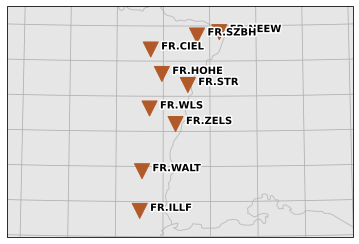

In [263]:
ax = inventory.plot(projection="local")

In [266]:
df_seisme

,horizontale,verticale,nom,distance,frequence,Ml,Mlv
station,,,,,,,
STR,0.002694,0.000554,Strasbourg,9839.470651,2.983333,2.777480,2.090549
HOHE,0.000203,0.000180,Hohengœft,24730.920314,3.361111,1.922862,1.869979
CIEL,0.000246,0.000121,Vacanciel,38657.037798,1.388889,2.257550,1.949050
NEEW,0.000084,0.000066,Neewiller,38969.213465,2.449932,1.796989,1.689643
ZELS,0.000065,0.000068,Zelsheim,42143.981841,1.649954,1.763280,1.763280
WALT,0.000049,0.000097,Westhalten,87090.321688,1.366629,2.724182,2.724182
ILLF,0.000048,0.000028,Illfurth,116453.372036,1.749951,2.943513,2.718585


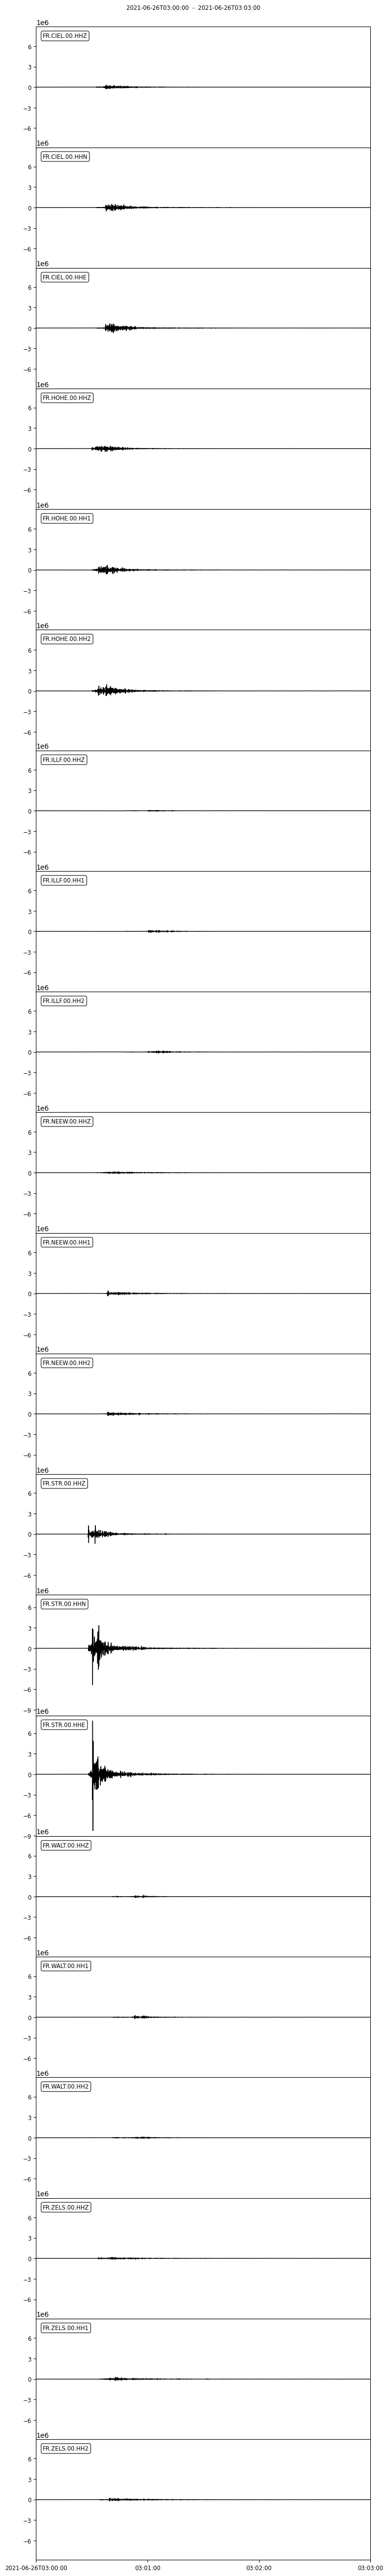

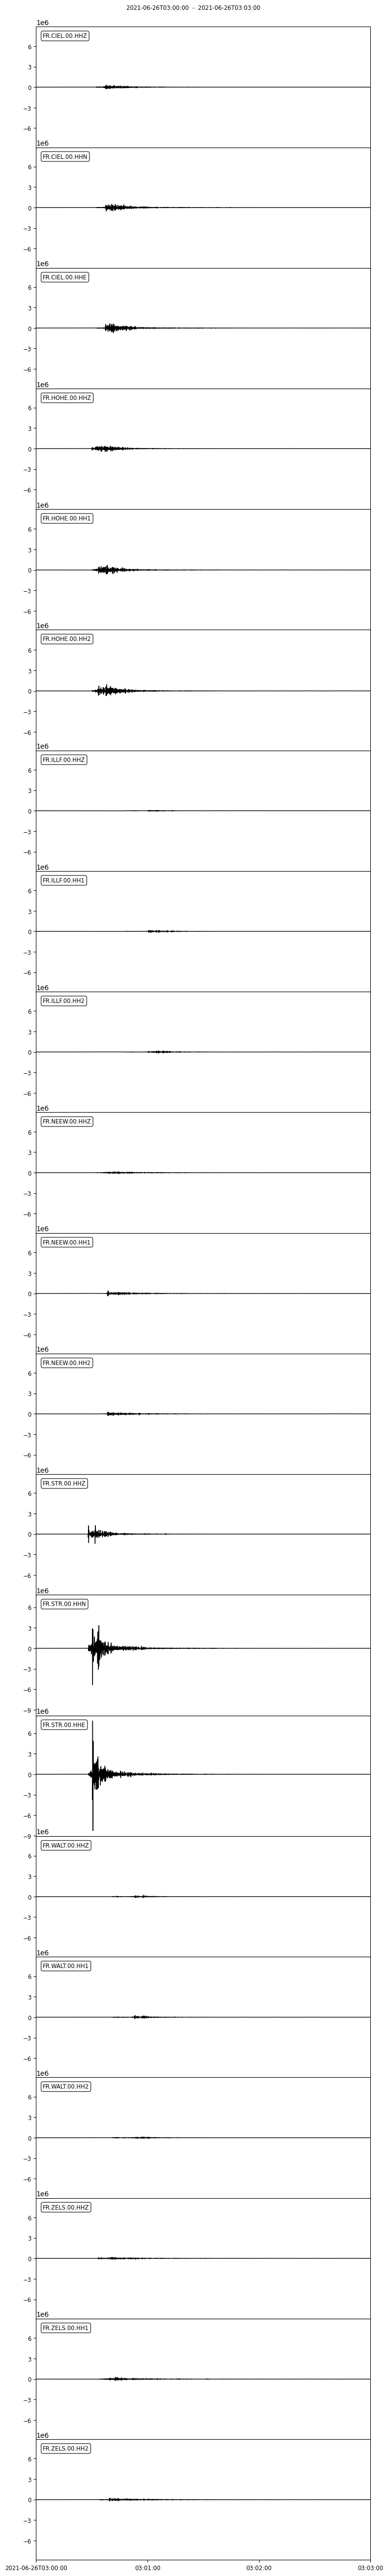

In [262]:
S.plot()

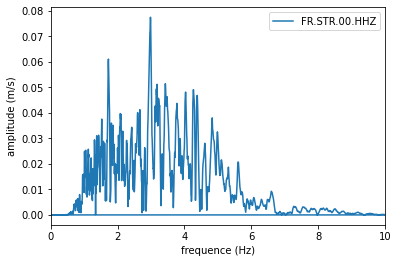

In [270]:
T = S.select(station='STR', component='Z')[0]
spectre(T)

## Utilisation de ces outils pour la mise en évidence de l'effet de site

In [223]:
to_float = lambda char: float(char.replace(',', '.'))

def download_seismes(df, local_path=local_path, duration=10*60, skip=True):
    """Télécharge les données des capteurs des séismes, les analyse, et les stock dans un dossier"""
    for row in df.iterrows():
        data = row[1]
        starttime = UTCDateTime(data.annee, data.mois, data.jour, data.heure, data.minute, 0)
        location = (to_float(data.lat), to_float(data.long))
        Mref = float(to_float(data.Mref))
        name = starttime.strftime("%d-%m-%y")
        folder = os.path.join(local_path, name)
        try:
            os.makedirs(folder)
            print(f'Created folder {folder}')
        except FileExistsError:
            print(f'Folder {folder} already exists')
            if skip:
                if os.path.isfile(os.path.join(folder, 'data.miniseed')):
                    print(f'Skipping : File {os.path.join(folder, "data.miniseed")} already exists')
                    continue
        try:
            S, inventory = download(stations=stations, path=folder, starttime=starttime, duration=duration)
            filtration(S)
            df_seisme = get_df(S, inventory)
            df_seisme.to_csv(os.path.join(folder, 'output.csv'), sep=';')
            S.plot(type='section', outfile=os.path.join(folder, 'output.png'))
            print(f'Successfully downloaded data from {df_seisme.shape[1]} stations')
        except Exception as e:
            print(f'Error downloading the data, raised {e}')

In [232]:
def compare(stations_comp=('ILLF', 'WLS'), colomn='verticale', local_path=local_path):
    """Compare plusieurs stations par rapport à différent facteurs sur différents séismes"""
    folders = [os.path.join(local_path, f) for f in os.listdir(local_path) if os.path.isdir(local_path)]
    data = {station: [] for station in stations_comp}
    skipped = 0
    for folder in folders:
        # S, inventory = load(path=folder, filename=filename)
        file = os.path.join(folder, f'output.csv')
        if os.path.exists(file):
            df_seisme = pd.read_csv(file, sep=';', index_col='station')
            if not any(station not in df_seisme.index for station in stations_comp):
                for station in stations_comp:
                    data[station].append(df_seisme[colomn][station])
            else:
                skipped += 1
    print(f'Skipped {skipped} event(s)')
    return pd.DataFrame(data=data)

## Séismes proches

In [240]:
folder_name = "seismes_proches"
local_path = os.path.join(path, folder_name)

In [243]:
df = pd.read_csv(f'{local_path}.csv', sep=';', index_col=0)

In [244]:
df

,annee,mois,jour,heure,minute,lat,long,Mref
0,2003,2,22,20,41,"48,31","6,66","5,4"
1,2004,12,5,1,52,"48,08","7,99","5,3"
2,2004,2,23,17,31,"47,28","6,27","5,1"
3,2009,5,5,1,39,"47,68","7,73",4
4,2021,6,26,3,0,"48,66","7,82","3,9"
5,2020,12,4,5,59,"48,66","7,81","3,6"
6,2018,5,4,21,36,"47,75","7,52","3,6"
7,2010,7,30,1,56,"48,81","7,71","3,4"
8,2021,1,22,18,33,"48,66","7,82","3,3"
9,2005,11,3,0,18,"48,29","7,43","3,3"


In [245]:
download_seismes(df, local_path=local_path, skip=True, duration=3*60)

Created folder data/seismes_proches/22-02-03
Error downloading the data, raised 'horizontale'
Created folder data/seismes_proches/05-12-04
Error downloading the data, raised 'horizontale'
Created folder data/seismes_proches/23-02-04
Error downloading the data, raised 'horizontale'
Created folder data/seismes_proches/05-05-09
Error downloading the data, raised 'horizontale'
Created folder data/seismes_proches/26-06-21
Successfully downloaded data from 7 stations
Created folder data/seismes_proches/04-12-20
Successfully downloaded data from 7 stations
Created folder data/seismes_proches/04-05-18
Successfully downloaded data from 7 stations
Created folder data/seismes_proches/30-07-10
Error downloading the data, raised 'horizontale'
Created folder data/seismes_proches/22-01-21
Successfully downloaded data from 7 stations
Created folder data/seismes_proches/03-11-05
Error downloading the data, raised 'horizontale'
Created folder data/seismes_proches/12-11-19
Successfully downloaded data fr

/home/definity/miniconda3/envs/sismo/lib/python3.9/site-packages/obspy/io/mseed/core.py:838: UserWarning: File will be written with more than one different encodings.
This might have a negative influence on the compatibility with other programs.
  warnings.warn(msg % 'encodings')


Successfully downloaded data from 7 stations
Created folder data/seismes_proches/06-12-12
Successfully downloaded data from 7 stations
Folder data/seismes_proches/04-12-20 already exists
Skipping : File data/seismes_proches/04-12-20/data.miniseed already exists


In [246]:
df_amplitudes = compare(local_path=local_path)

Skipped 8 event(s)


In [247]:
df_amplitudes

,ILLF,WLS
0,0.000002,2.780761e-07
1,0.000002,2.542491e-06
2,0.000020,3.624085e-06
3,0.000016,9.079874e-07
4,0.000005,2.561978e-06
5,0.000043,3.853055e-05
6,0.000009,6.021859e-07
7,0.000002,1.718636e-07
8,0.000001,2.618877e-07


In [248]:
values = df_amplitudes[df_amplitudes.columns[0]]/df_amplitudes[df_amplitudes.columns[1]]
np.average(values)

7.6536153310414381

Text(0, 0.5, 'Amplitude maximale')

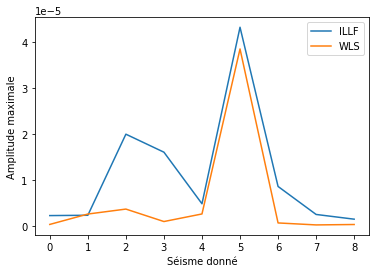

In [255]:
df_amplitudes.plot()
plt.xlabel('Séisme donné')
plt.ylabel('Amplitude maximale')

(-1.7460708842480002e-06, 4.5355049347396505e-05)

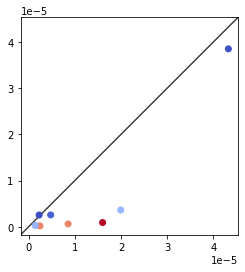

In [251]:
fig, ax = plt.subplots()
ax.scatter(df_amplitudes['ILLF'], df_amplitudes['WLS'], c=values, cmap=plt.cm.coolwarm)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

## Séismes loin

In [188]:
folder_name = "seismes_loin"
local_path = os.path.join(path, folder_name)

In [189]:
df = pd.read_csv(f'{local_path}.csv', sep=';', index_col=0)

In [190]:
df

,annee,mois,jour,heure,minute,lat,long,Mref
0,2021,11,1,22,8,"18,5","-62,32","5,2"
1,2021,8,28,11,20,"35,8","-3,31","5,2"
2,2021,6,8,3,59,"43,72","16,05",5
3,2021,4,6,8,54,"45,06","17,15","5,1"
4,2021,1,24,23,21,"18,23","-63,9","5,4"
5,2020,12,30,5,26,"45,68","15,91","5,1"
6,2021,1,6,17,1,"45,56","16,06","5,4"
7,2020,10,7,18,24,"18,16","-64,38","5,6"
8,2020,10,4,19,12,11.02,"-61,51","5,2"
9,2020,7,4,7,59,"36,16","7,27","5,3"


In [225]:
download_seismes(df, local_path=local_path, skip=True)

Folder data/seismes_loin/01-11-21 already exists
Skipping : File data/seismes_loin/01-11-21/data.miniseed already exists
Folder data/seismes_loin/28-08-21 already exists
Skipping : File data/seismes_loin/28-08-21/data.miniseed already exists
Folder data/seismes_loin/08-06-21 already exists
Skipping : File data/seismes_loin/08-06-21/data.miniseed already exists
Folder data/seismes_loin/06-04-21 already exists
Skipping : File data/seismes_loin/06-04-21/data.miniseed already exists
Folder data/seismes_loin/24-01-21 already exists
Skipping : File data/seismes_loin/24-01-21/data.miniseed already exists
Folder data/seismes_loin/30-12-20 already exists
Skipping : File data/seismes_loin/30-12-20/data.miniseed already exists
Folder data/seismes_loin/06-01-21 already exists
Skipping : File data/seismes_loin/06-01-21/data.miniseed already exists
Folder data/seismes_loin/07-10-20 already exists
Successfully downloaded data from 7 stations
Created folder data/seismes_loin/04-10-20
Successfully down

In [233]:
df_amplitudes = compare(local_path=local_path)

Skipped 1 event(s)


In [234]:
df_amplitudes

,ILLF,WLS
0,1.530144e-07,2.543213e-08
1,1.720693e-06,2.351014e-07
2,6.737722e-07,9.032786e-08
3,1.524628e-07,6.952519e-08
4,8.718503e-07,8.907256e-07
5,1.156709e-06,2.507872e-07
6,2.295315e-06,5.272901e-06
7,7.116576e-08,6.621429e-09
8,8.260865e-07,4.427349e-07
9,1.556923e-05,6.567168e-06


In [235]:
values = df_amplitudes[df_amplitudes.columns[0]]/df_amplitudes[df_amplitudes.columns[1]]
np.average(values)

7.7815490570715111

<AxesSubplot:>

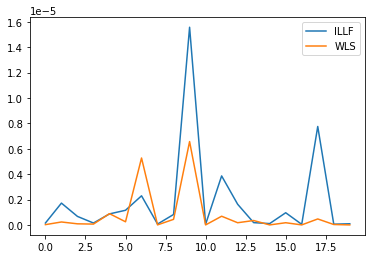

In [237]:
df_amplitudes.plot()

(-7.270680517579151e-07, 1.6345240974445615e-05)

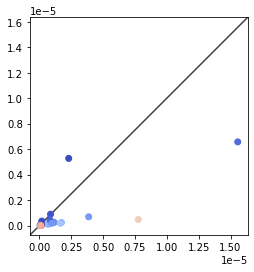

In [187]:
fig, ax = plt.subplots()
ax.scatter(df_amplitudes['ILLF'], df_amplitudes['WLS'], c=df_amplitudes['rapport'], cmap=plt.cm.coolwarm)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# Commandes utiles

In [ ]:
os.makedirs(local_path)

In [239]:
df = pd.read_clipboard()

In [241]:
df.to_csv(f'{local_path}.csv', sep=';')